### Maker Collateral Risk Model - Feature Analysis

In [38]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import plotly.express as px
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns
sns.set_style('darkgrid')

### EDA

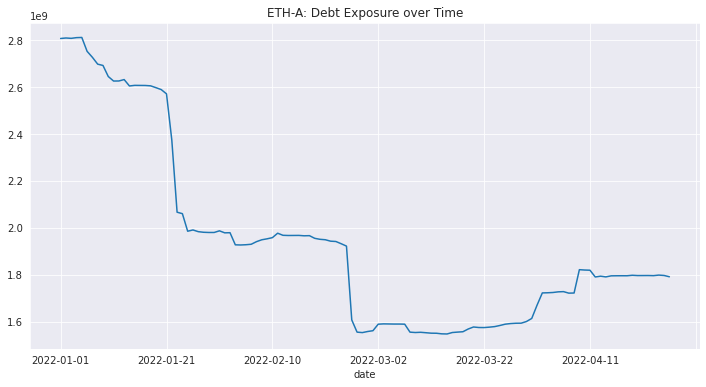

In [39]:
data = pd.read_csv('data.csv')
data.set_index('date')['total_debt'].plot(kind='line', figsize=(12,6), title="ETH-A: Debt Exposure over Time");

In [40]:
feature_names = ['total_debt', 'share_vaults_protected', 'collateralization_ratio', 'liq_score']
target_name = ['risk_premium']
data = data[feature_names+target_name].dropna()

In [41]:
X = np.array(data[feature_names])
y = np.array(data[target_name])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

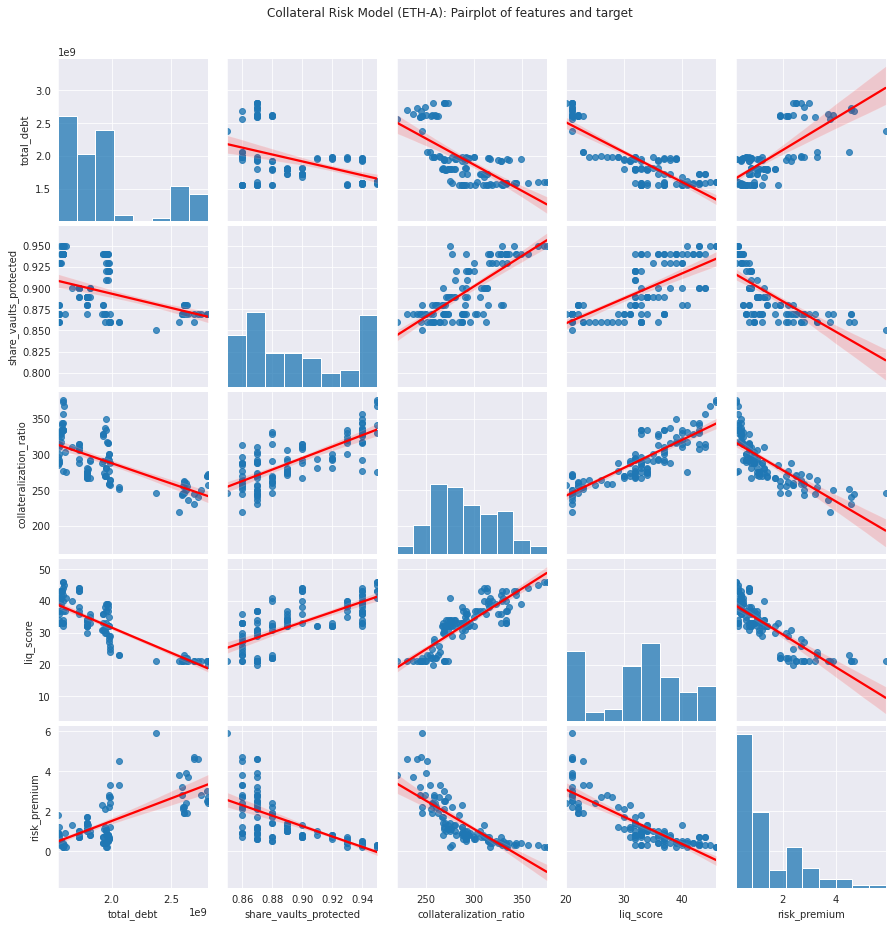

In [42]:
g = sns.pairplot(data, kind='reg', plot_kws={'line_kws':{'color':'red'}})
g.fig.suptitle(f"Collateral Risk Model (ETH-A): Pairplot of features and target", y=1.03)
g.fig.savefig("pairplot_fig.png");

### Model Fitting

In [46]:
# train a lightGBM regression model
est = LGBMRegressor()
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}
search = GridSearchCV(est, param_grid, n_jobs=-1, scoring='r2')

In [47]:
search.fit(X_train, y_train)
print("Best estimator: ", search.best_params_);

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Best estimator:  {'learning_rate': 0.1, 'max_depth': 3}


In [48]:
# Mean cross-validated score of the best_estimator
print("Test set score: ", search.best_estimator_.score(X_test, y_test))

Test set score:  0.8283329221667843


### SHAP

In [49]:
# Correlation interpretation
fitted_model = search.best_estimator_

explainer = shap.Explainer(fitted_model, feature_names=feature_names)
shap_values = explainer(X_test)

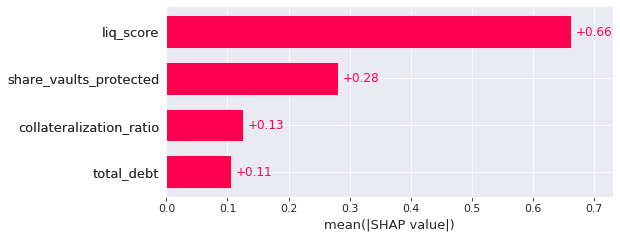

In [50]:
# feature importance
shap.plots.bar(shap_values)

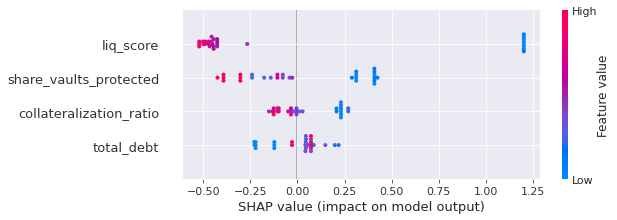

In [51]:
shap.summary_plot(shap_values)

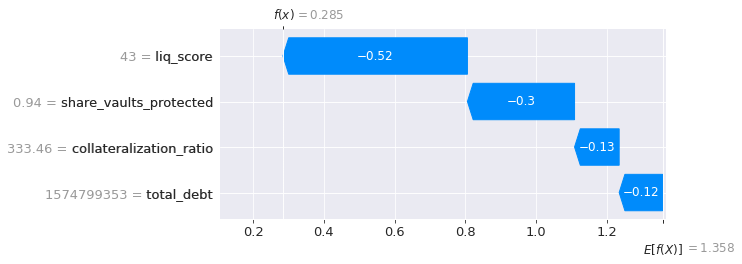

In [52]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

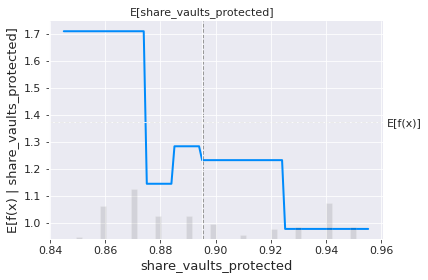

In [55]:
# negative correlation between share of vaults protected and risk premium
shap.plots.partial_dependence(
    "share_vaults_protected",
    fitted_model.predict,
    pd.DataFrame(X, columns=feature_names),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)